# Изучение особенностей задач поиска и локализации объектов на изображениях на основе библиотеки Detectron2

## Зарузка необходимых библиотек

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION  = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

сolab_requirements = ["pip install pyyaml==5.1",
                      "pip install --upgrade urllib3==1.25",
                      # "python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'"
                      ]

import sys, subprocess

def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    for i in сolab_requirements:
        run_subprocess_command(i)

torch:  2.0 ; cuda:  2.0.0


In [ ]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION  = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/{CUDA_VERSION}/{TORCH_VERSION}/index.html

!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

import os
os.kill(os.getpid(), 9)

torch:  2.0 ; cuda:  2.0.0
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-gmywinfu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-gmywinfu
  Resolved https://github.com/facebookresearch/detectron2.git to commit a0e22dbfa791e6235e4f196d5ce25e754d02be31
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for pycocotools>=2.0.2 from https://files.pythonhosted.org/packages/ba/64/0451cf41a00fd5ac4501de4ea0e395b7d909e09d665e56890b5d3809ae26/pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 17.7 MB/s eta 0:00:00
  Obtaining dependency information for black from https

In [ ]:
import detectron2
import torch, torchvision

In [ ]:
import numpy as np
import os, json, cv2, random
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
from detectron2        import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data             import MetadataCatalog, DatasetCatalog
from detectron2.structures       import BoxMode
from detectron2.data.datasets    import register_coco_instances, load_coco_json
from detectron2.utils.logger     import setup_logger
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation       import COCOEvaluator, inference_on_dataset
from detectron2.data             import build_detection_test_loader

In [ ]:
def torch_stats():
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32

    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)

        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)

    num_workers=os.cpu_count() #torch.get_num_threads()
    print ('available number of workers:',num_workers)

    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn

In [ ]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 2.0
Using device: cuda
cuda:  2.0.0
Cuda is available: True
number of devices: 2
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
default data type: torch.float32
available number of workers: 4


In [ ]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchsummary import summary

from tqdm.notebook import tqdm, trange

import pandas as pd


# from albumentations.pytorch import ToTensorV2
# import albumentations as A

import shutil
from urllib.request import urlretrieve
from torchvision.datasets.utils import download_and_extract_archive

In [ ]:
from detectron2.model_zoo.model_zoo import _ModelZooUrls

**Упражнение 1**
1. Попробуйте повычить точность решения, используя `model_zoo`;
2. Попробуйте преобразовать показанные примеры в решение проблемы `object detection` для набора данных Balloon.
3. (ОПЦИОНАЛЬНО) Попробуйте обучить модель для задачи обнаружения окон и зданий по ссылке
https://github.com/InformationSystemsFreiburg/image_segmentation_japan/raw/master/buildings.zip
<!-- as hint you may use this link https://rosenfelder.ai/Instance_Image_Segmentation_for_Window_and_Building_Detection_with_detectron2/ -->
*Примечание* набор имеет формат COCO

<!--
3. Try to build an instance segmentation model for the  blood cells dataset, that you may find here: https://public.roboflow.com/object-detection/bccd
<!-- as hint you may use this link https://blog.roboflow.com/how-to-train-detectron2/
*Note* you will need to register for download data, please download data in the COCO format
https://colab.research.google.com/drive/1-TNOcPm3Jr3fOJG8rnGT9gh60mHUsvaW#scrollTo=QvbWgc7HhfWi -->

## 1. Попробуйте повычить точность решения, используя model_zoo

Данные balloon

In [ ]:
# download, decompress the data
url = "https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip"

root_directory = os.path.join(os.getcwd(),'')

archive_name = url.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)
# dataset_directory = os.path.splitext(dataset_directory)[0]
dataset_directory = os.path.join(root_directory, 'balloon')

download_and_extract_archive(url, root_directory)

100%|██████████| 38741381/38741381 [00:00<00:00, 314714603.36it/s]


Extracting /kaggle/working/balloon_dataset.zip to /kaggle/working/


In [ ]:
content = os.listdir(dataset_directory)
print(content)

['val', 'train']


Приведем данные к необходимому виду

In [ ]:
from detectron2.structures import BoxMode

def balloon2COCO(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}

        filename = os.path.join(img_dir, v["filename"])
        height, width = np.asarray(Image.open(filename)).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px)-np.min(px), np.max(py)-np.min(py)],
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [ ]:
val_dir   = os.path.join(dataset_directory, 'val')
train_dir = os.path.join(dataset_directory, 'train')

In [ ]:
try:
    DatasetCatalog.pop("balloon_train")
except:
    pass

try:
    DatasetCatalog.pop("balloon_val")
except:
    pass

In [ ]:

try:
    DatasetCatalog.register("balloon_train", lambda : balloon2COCO("balloon/train"))
except:
    print('Probably data %s have been already registred')

try:
    DatasetCatalog.register("balloon_val", lambda : balloon2COCO("balloon/val"))
except:
    print('Probably data %s have been already registred')

MetadataCatalog.get("balloon_train").set(thing_classes=["balloon"])
MetadataCatalog.get("balloon_val").set(thing_classes=["balloon"])

namespace(name='balloon_val', thing_classes=['balloon'])

In [ ]:
balloon_metadata = MetadataCatalog.get("balloon_train")
dataset_dicts    = balloon2COCO("balloon/train")

In [ ]:
balloon_metadata.as_dict()

{'name': 'balloon_train', 'thing_classes': ['balloon']}

In [ ]:
print('N Train',len(dataset_dicts))
print(dataset_dicts[0].keys())

N Train 61
dict_keys(['file_name', 'image_id', 'height', 'width', 'annotations'])


Теперь посмотрим на 2 изображения из набора данных, чтобы убедиться, что регистрация набора прошла успешно.

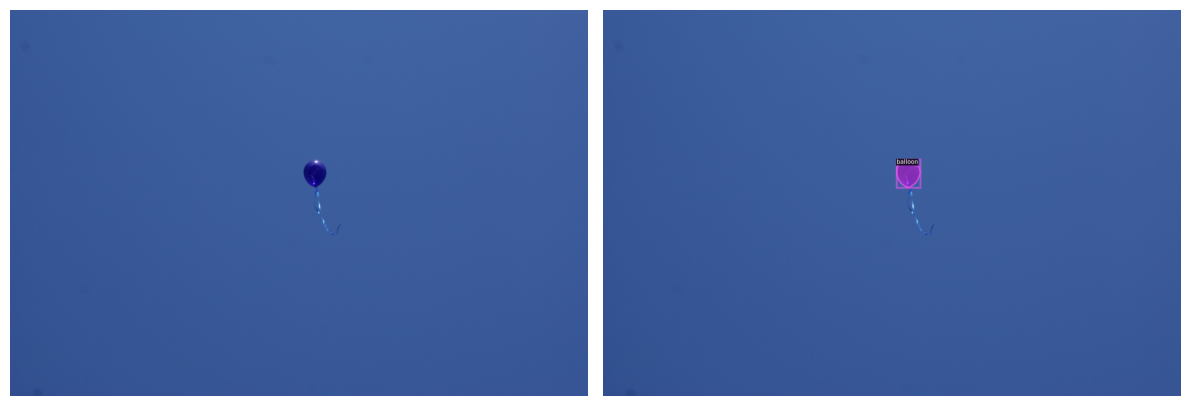

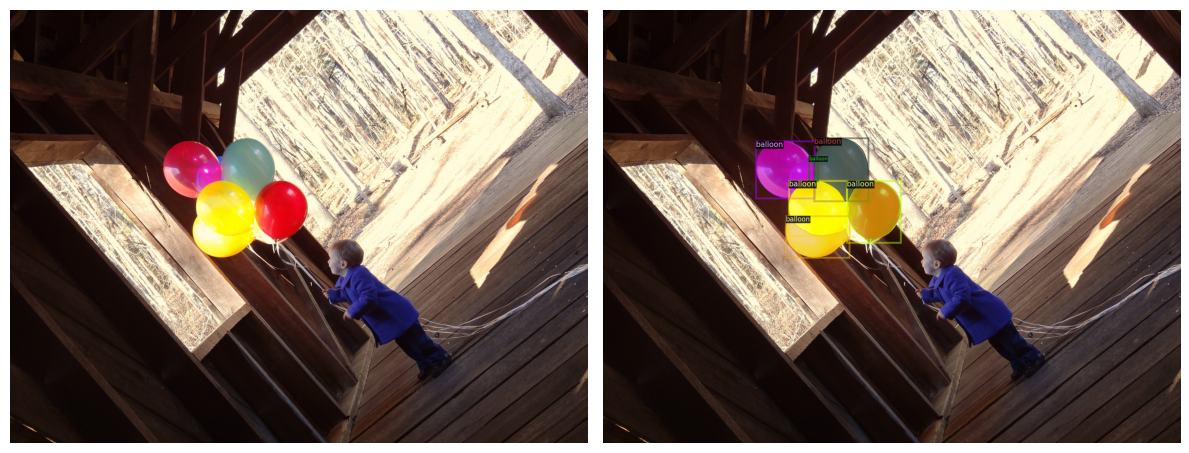

In [ ]:
for d in random.sample(dataset_dicts, 2):
    img   = Image.open(d["file_name"])
    _,axs = plt.subplots(1,2,figsize=(12,8))
    axs[0].imshow(img); axs[0].axis('off')
    visualizer = Visualizer(img, metadata=balloon_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    axs[1].imshow(out.get_image()); axs[1].axis('off')
    plt.tight_layout();plt.show()

In [ ]:
def plot_instant(image, mask, bbox):

    fig, axs = plt.subplots(1, 4, figsize = (18,6))
    image_ = np.copy(np.asarray(image)).astype(float)/image.max()

    # Ground Truth
    axs[0].imshow(np.clip(image_,0,1), 'gray')
    axs[0].axis('off'); axs[0].set_title('Original Image')
    #----------------------------

    # Semantic Segmentaion
    mask_ = np.asarray(mask).sum(2)
    mask_[mask_>0]=255
    axs[1].imshow(mask_, 'gray')
    axs[1].axis('off'); axs[1].set_title('Semantic Segmentaion')
    #----------------------------

    # Instance Segmentation
    out  = np.zeros((*mask.shape[:2],3),dtype=float)
    for i,mask_ in enumerate(mask.transpose((2,0,1))):
        ch_  = i%3
        mask_ = mask_*(np.random.rand()*0.5 + 0.5)
        out[:,:,ch_]  = out[:,:,ch_]*0.9 + mask_[:,:]

    axs[2].imshow(np.clip(out/out.max(),0,1), 'gray')
    axs[2].axis('off'); axs[2].set_title('Instance Segmentation')
    #----------------------------

    # Object Detection BBoxes
    bbox_ = np.asarray(bbox)
    axs[3].imshow(np.clip(image_,0,1), 'gray')
    for box_ in bbox_:
        bb = patches.Rectangle(xy     = (box_[0],box_[1]),
                               width  = box_[2]-box_[0],
                               height = box_[3]-box_[1],
                               linewidth=2,
                               edgecolor="blue",
                               facecolor="none")
        axs[3].add_patch(bb)
    axs[3].axis('off'); axs[3].set_title('Object Detection')

    plt.tight_layout()
    plt.show()

Реализуем свой способ визуализации

In [ ]:
from pycocotools import mask as cocoutils

def get_masks(image_anno):
    h = image_anno['height']
    w = image_anno['width' ]
    mask_anns = image_anno['annotations']
    mask = np.zeros((h,w, len(mask_anns)))
    for i,ann in enumerate(mask_anns):
        mask[:,:,i] = _ann2mask(ann,h,w)
    return mask

def _ann2mask(ann, h,w):
    segm = ann['segmentation']
    rles = cocoutils.frPyObjects(segm, h, w)
    rle  = cocoutils.merge(rles)
    instant_mask = cocoutils.decode(rle)
    return instant_mask

def get_bboxes(image_anno):
    bboxes = np.zeros((len(image_anno['annotations']),4),dtype=int)#x0,y0,w,h

    for i,ann in enumerate(image_anno['annotations']):
        bboxes[i] = ann['bbox']
    bboxes[:,2] = bboxes[:,0]+bboxes[:,2] #x-max
    bboxes[:,3] = bboxes[:,1]+bboxes[:,3] #y-max
    return bboxes

balloon/train/34020010494_e5cb88e1c4_k.jpg


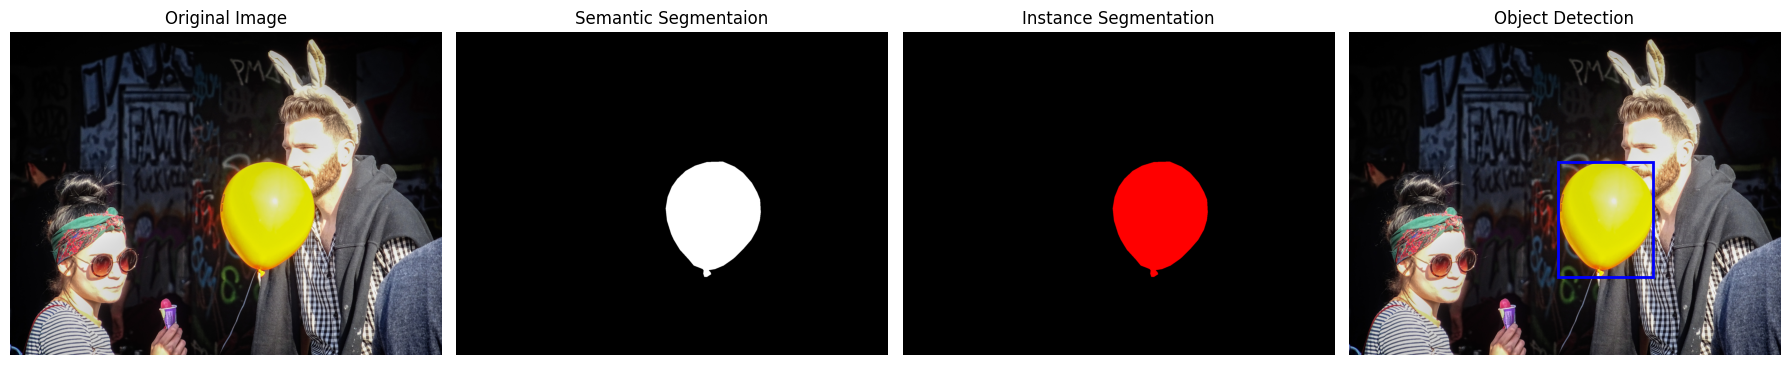

In [ ]:

d = dataset_dicts[0]
print(d['file_name'])

image = np.asarray(Image.open(d["file_name"]))


masks = get_masks(d)
boxes = get_bboxes(d)

plot_instant(image, masks, boxes)

После того, как набор данных успешно загружен можно провести тренеровку нейронной сети. В нашем случае мы будем проводить дообучение модели для задачи instace segmentataion использованной ранее модели, обученной на датасете COCO .

Сначала рассмотрим пример с моделью из исходного ноутбука и сравним с другой моделью из model_zoo

In [ ]:
from detectron2.engine import DefaultTrainer

In [ ]:
from detectron2.data import build_detection_test_loader, build_detection_train_loader

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [ ]:
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import copy
import torch

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below

    image = utils.read_image(dataset_dict["file_name"], format="BGR")

    transform_list = [
                        T.Resize((800,600)),
                        T.RandomBrightness(0.8, 1.8),
                        T.RandomContrast(0.6, 1.3),
                        T.RandomSaturation(0.8, 1.4),
                        T.RandomRotation(angle=[90, 90]),
                        T.RandomLighting(0.7),
                        T.RandomFlip(prob=0.4, horizontal=False, vertical=True),
                    ]

    image, transforms = T.apply_transform_gens(transform_list, image)

    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]

    instances = utils.annotations_to_instances(annos, image.shape[:2])

    dataset_dict["instances"] = utils.filter_empty_instances(instances)

    return dataset_dict

Проведем конфигурацию модели

In [ ]:
BATCH = 2

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = BATCH
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

Тренировка

In [ ]:
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True);
trainer = CustomTrainer(cfg)#DefaultTrainer(cfg);

trainer.resume_or_load(resume=False)

model_final_f10217.pkl: 178MB [00:00, 241MB/s]                             


In [ ]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("balloon_val", )
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

Посмотрим на результат на валидационной выборке

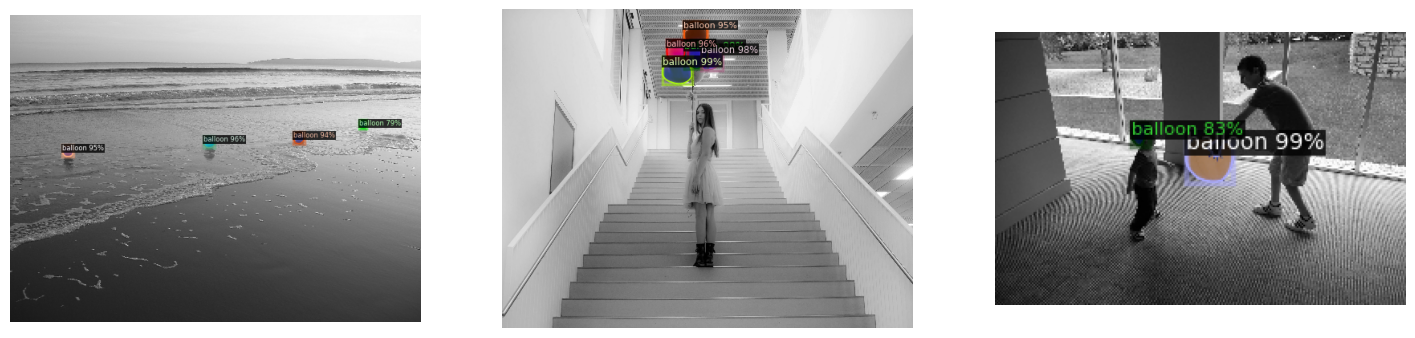

In [ ]:
dataset_dicts = balloon2COCO("balloon/val")

_, axs = plt.subplots(1,3,figsize=(18,6))

for i,d in enumerate(random.sample(dataset_dicts, 3)):
    im = np.asarray(Image.open(d["file_name"]))
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata,
                   scale=0.25,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[i].imshow(out.get_image()); axs[i].axis('off');
plt.show()

Посмотрим на колличественную оценку точности

In [ ]:
evaluator  = COCOEvaluator(dataset_name = "balloon_val",
                           tasks        = ("bbox", "segm"),
                           distributed  = False,
                           output_dir   = "./output/")

In [ ]:
val_loader = build_detection_test_loader(cfg, "balloon_val")

In [ ]:
print(inference_on_dataset(trainer.model, val_loader, evaluator))

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.882
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.851
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.146
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.580
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.894
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.790
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.848
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.533
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.788
 Average Recall     (AR) @[ IoU=0.50:0.

Рассмотрим другую модель

In [ ]:
from detectron2.model_zoo.model_zoo import _ModelZooUrls
mz = _ModelZooUrls()
print("\n".join(list(mz.CONFIG_PATH_TO_URL_SUFFIX.keys())))

COCO-Detection/faster_rcnn_R_50_C4_1x
COCO-Detection/faster_rcnn_R_50_DC5_1x
COCO-Detection/faster_rcnn_R_50_FPN_1x
COCO-Detection/faster_rcnn_R_50_C4_3x
COCO-Detection/faster_rcnn_R_50_DC5_3x
COCO-Detection/faster_rcnn_R_50_FPN_3x
COCO-Detection/faster_rcnn_R_101_C4_3x
COCO-Detection/faster_rcnn_R_101_DC5_3x
COCO-Detection/faster_rcnn_R_101_FPN_3x
COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x
COCO-Detection/retinanet_R_50_FPN_1x
COCO-Detection/retinanet_R_50_FPN_3x
COCO-Detection/retinanet_R_101_FPN_3x
COCO-Detection/rpn_R_50_C4_1x
COCO-Detection/rpn_R_50_FPN_1x
COCO-Detection/fast_rcnn_R_50_FPN_1x
COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x
COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_1x
COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x
COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x
COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x
COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x
COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x
COCO-InstanceSegmentation/mask_rcnn_R_101_DC5_3x
COCO-Insta

In [ ]:
BATCH = 2

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = BATCH
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

In [ ]:
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True);
trainer = CustomTrainer(cfg)#DefaultTrainer(cfg);

trainer.resume_or_load(resume=False)

model_final_721ade.pkl: 136MB [00:00, 185MB/s]                             


In [ ]:
trainer.train()

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("balloon_val", )
predictor = DefaultPredictor(cfg)

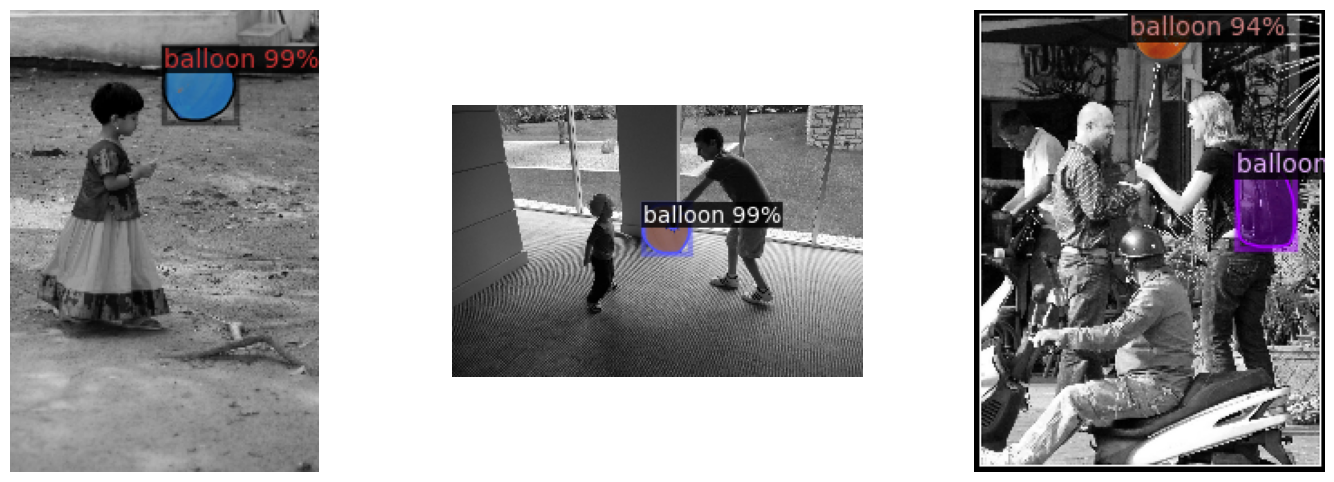

In [ ]:
dataset_dicts = balloon2COCO("balloon/val")

_, axs = plt.subplots(1,3,figsize=(18,6))

for i,d in enumerate(random.sample(dataset_dicts, 3)):
    im = np.asarray(Image.open(d["file_name"]))
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata,
                   scale=0.25,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[i].imshow(out.get_image()); axs[i].axis('off');
plt.show()

Видно, что какие то объекты модель распознает не верно

In [ ]:
evaluator  = COCOEvaluator(dataset_name = "balloon_val",
                           tasks        = ("bbox", "segm"),
                           distributed  = False,
                           output_dir   = "./output/")

In [ ]:
val_loader = build_detection_test_loader(cfg, "balloon_val")

In [ ]:
print(inference_on_dataset(trainer.model, val_loader, evaluator))

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.756
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.909
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.878
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.557
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.876
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.232
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.772
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.729
 Average Recall     (AR) @[ IoU=0.50:0.

Однако, если посмотреть на числовой результат, видно, что модель лучше предыдущей, скорее всего это связано с тем, что первоначальная модель также ошибалась, но при проведении визуализации удачно папались правильные результаты

### 2. Попробуйте преобразовать показанные примеры в решение проблемы object detection для набора данных Balloon.

In [ ]:
from detectron2.model_zoo.model_zoo import _ModelZooUrls
mz = _ModelZooUrls()
print("\n".join(list(mz.CONFIG_PATH_TO_URL_SUFFIX.keys())))

COCO-Detection/faster_rcnn_R_50_C4_1x
COCO-Detection/faster_rcnn_R_50_DC5_1x
COCO-Detection/faster_rcnn_R_50_FPN_1x
COCO-Detection/faster_rcnn_R_50_C4_3x
COCO-Detection/faster_rcnn_R_50_DC5_3x
COCO-Detection/faster_rcnn_R_50_FPN_3x
COCO-Detection/faster_rcnn_R_101_C4_3x
COCO-Detection/faster_rcnn_R_101_DC5_3x
COCO-Detection/faster_rcnn_R_101_FPN_3x
COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x
COCO-Detection/retinanet_R_50_FPN_1x
COCO-Detection/retinanet_R_50_FPN_3x
COCO-Detection/retinanet_R_101_FPN_3x
COCO-Detection/rpn_R_50_C4_1x
COCO-Detection/rpn_R_50_FPN_1x
COCO-Detection/fast_rcnn_R_50_FPN_1x
COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x
COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_1x
COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x
COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x
COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x
COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x
COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x
COCO-InstanceSegmentation/mask_rcnn_R_101_DC5_3x
COCO-Insta

Рассмотрим модель для работы с object detection

In [ ]:
BATCH = 2

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = BATCH
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

In [ ]:
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True);
trainer = CustomTrainer(cfg)#DefaultTrainer(cfg);

trainer.resume_or_load(resume=False)

In [ ]:
trainer.train()

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("balloon_val", )
predictor = DefaultPredictor(cfg)

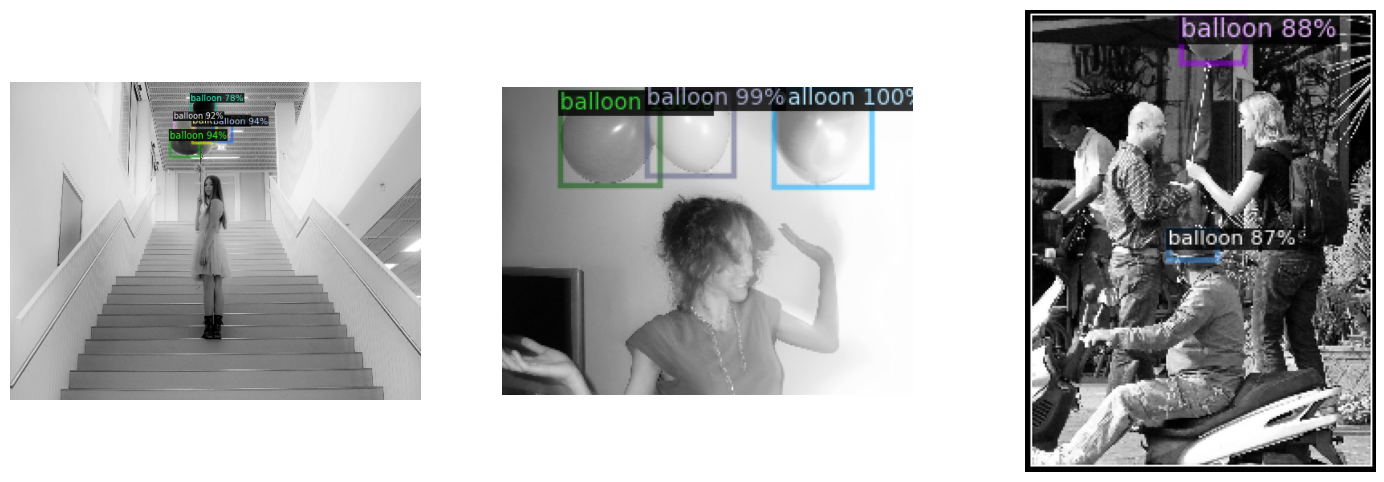

In [ ]:
dataset_dicts = balloon2COCO("balloon/val")

_, axs = plt.subplots(1,3,figsize=(18,6))

for i,d in enumerate(random.sample(dataset_dicts, 3)):
    im = np.asarray(Image.open(d["file_name"]))
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata,
                   scale=0.25,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[i].imshow(out.get_image()); axs[i].axis('off');
plt.show()

Также видно, что модель находит шары, однако, есть случаи, когда ошибается, принимая голову за шар, как на фото выше

### 3. Попробуйте обучить модель для задачи обнаружения окон и зданий по ссылке

Проведем загрузку данных

In [ ]:
!wget https://github.com/InformationSystemsFreiburg/image_segmentation_japan/raw/master/buildings.zip
!unzip buildings.zip > /dev/null

--2023-12-14 08:52:41--  https://github.com/InformationSystemsFreiburg/image_segmentation_japan/raw/master/buildings.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/InformationSystemsFreiburg/image_segmentation_japan/master/buildings.zip [following]
--2023-12-14 08:52:41--  https://raw.githubusercontent.com/InformationSystemsFreiburg/image_segmentation_japan/master/buildings.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23618597 (23M) [application/zip]
Saving to: 'buildings.zip'

buildings.zip       100%[===================>]  22.52M  --.-KB/s    in 0.1s    

2023-12-14 08:52:42 (159 M

Рассмотрим обнраужение зданий

In [ ]:
from detectron2.structures import BoxMode

def buildings2COCO(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}

        filename = os.path.join(img_dir, v["filename"])
        height, width = np.asarray(Image.open(filename)).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        annos = v["regions"]
        objs = []

        for anno in annos:

            anno_class = anno["region_attributes"]
            anno = anno["shape_attributes"]


            if "all_points_x" in anno:
                try:
                    if list(anno_class['class'].keys()) == ['building'] or anno_class['class'] == 'building':
                        px = anno["all_points_x"]
                        py = anno["all_points_y"]
                        poly = [(x, y) for x, y in zip(px, py)]
                        poly = [p for x in poly for p in x]

                        obj = {
                            "bbox": [np.min(px), np.min(py), np.max(px)-np.min(px), np.max(py)-np.min(py)],
                            "bbox_mode": BoxMode.XYWH_ABS,
                            "segmentation": [poly],
                            "category_id": 0,
                        }
                        objs.append(obj)
                except: continue
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [ ]:
root_directory= '/kaggle/working'

In [ ]:
val_dir   = os.path.join(root_directory, 'val')
train_dir = os.path.join(root_directory, 'train')

In [ ]:
try:
    DatasetCatalog.pop("buildings_train")
except:
    pass

try:
    DatasetCatalog.pop("buildings_val")
except:
    pass

In [ ]:
try:
    DatasetCatalog.register("buildings_train", lambda : buildings2COCO("train"))
except:
    print('Probably data %s have been already registred')

try:
    DatasetCatalog.register("buildings_val", lambda : buildings2COCO("val"))
except:
    print('Probably data %s have been already registred')

MetadataCatalog.get("buildings_train").set(thing_classes=["building"])


namespace(name='buildings_train', thing_classes=['building'])

In [ ]:
MetadataCatalog.get("buildings_val").set(thing_classes=["building"])

namespace(name='buildings_val', thing_classes=['building'])

In [ ]:
balloon_metadata = MetadataCatalog.get("buildings_train")
dataset_dicts    = buildings2COCO("train")

In [ ]:
balloon_metadata.as_dict()

{'name': 'buildings_train', 'thing_classes': ['building']}

In [ ]:
print('N Train',len(dataset_dicts))
print(dataset_dicts[0].keys())

N Train 129
dict_keys(['file_name', 'image_id', 'height', 'width', 'annotations'])


Посмотрим на данные

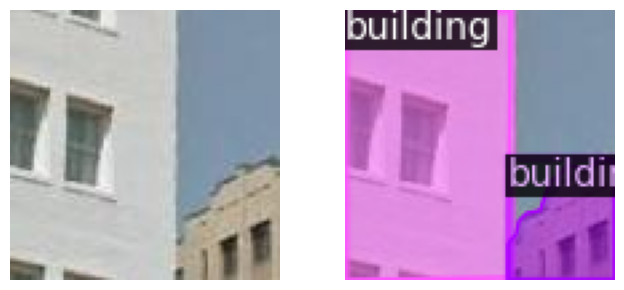

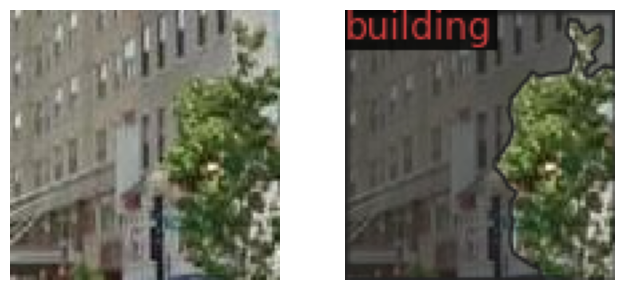

In [ ]:
for d in random.sample(dataset_dicts, 2):
    img   = Image.open(d["file_name"])
    _,axs = plt.subplots(1,2,figsize=(7,3))
    axs[0].imshow(img); axs[0].axis('off')
    visualizer = Visualizer(img, metadata=balloon_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    axs[1].imshow(out.get_image()); axs[1].axis('off')
    plt.tight_layout();plt.show()

train/0004-0143409_p.jpg


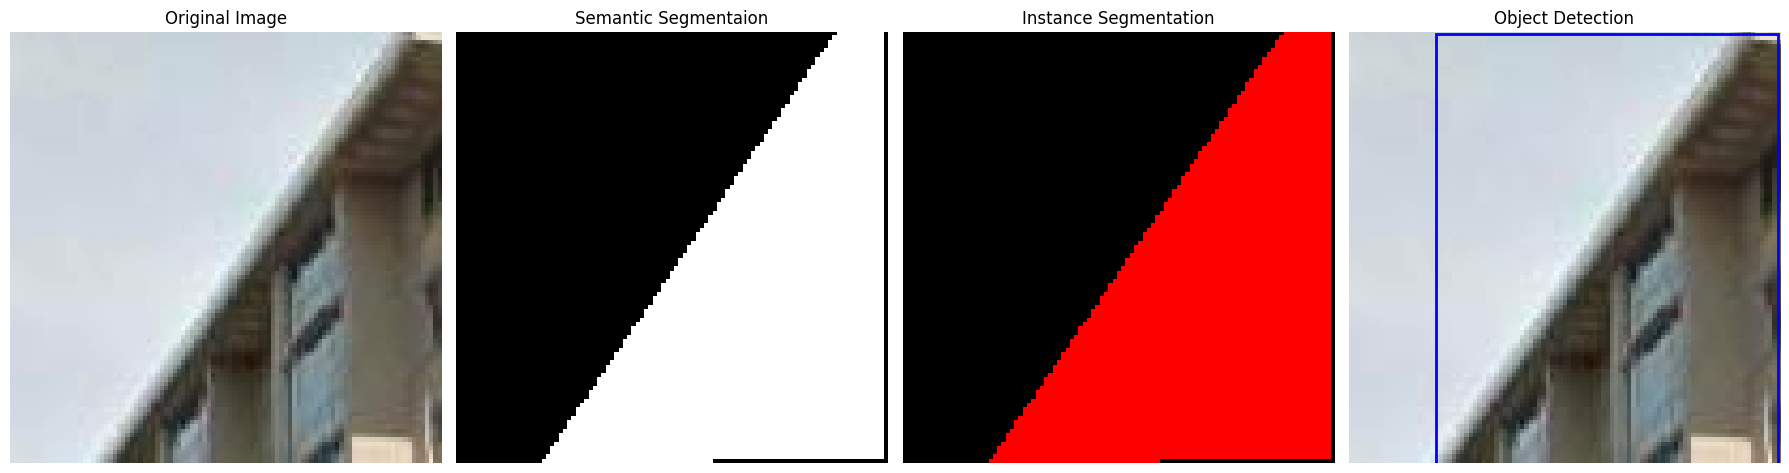

In [ ]:

d = dataset_dicts[0]
print(d['file_name'])

image = np.asarray(Image.open(d["file_name"]))


masks = get_masks(d)
boxes = get_bboxes(d)

plot_instant(image, masks, boxes)

Проведем конфигурацию модели

In [ ]:
from detectron2.engine import DefaultTrainer

In [ ]:
BATCH = 2

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("buildings_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = BATCH
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

Обучим модель

In [ ]:
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True);
trainer = CustomTrainer(cfg)#DefaultTrainer(cfg);

trainer.resume_or_load(resume=False)

model_final_f10217.pkl: 178MB [00:01, 138MB/s]                             


In [ ]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("buildings_val", )
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

Посмотрим на результат работы модели на валидационной выборке

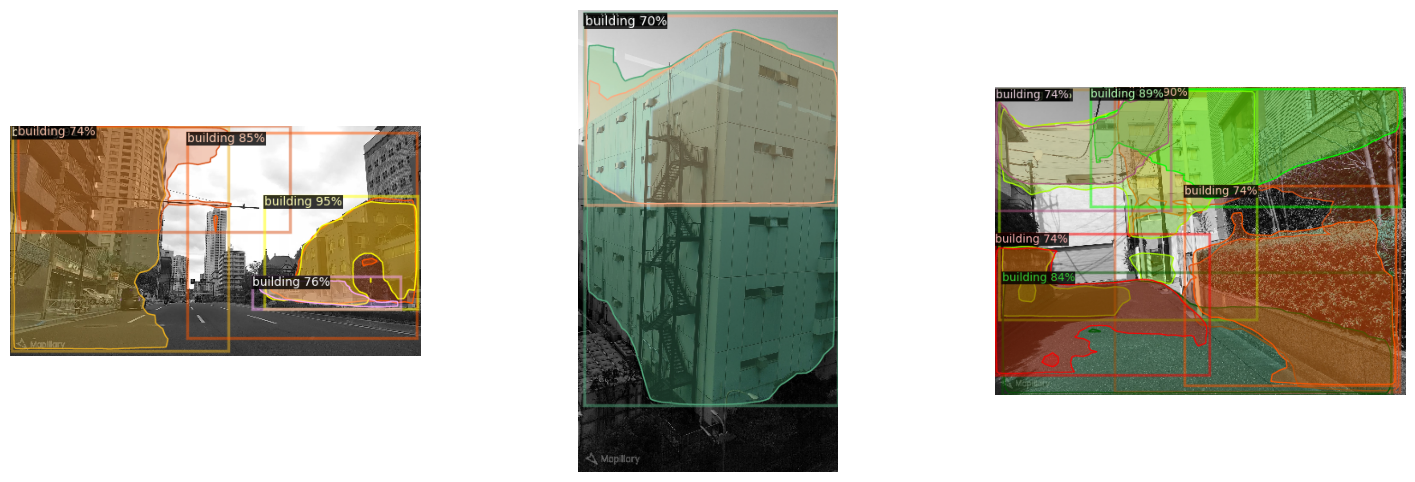

In [ ]:
dataset_dicts = buildings2COCO("val")

_, axs = plt.subplots(1,3,figsize=(18,6))

for i,d in enumerate(random.sample(dataset_dicts, 3)):
    im = np.asarray(Image.open(d["file_name"]))
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata,
                   scale=0.25,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[i].imshow(out.get_image()); axs[i].axis('off');
plt.show()

In [ ]:
evaluator  = COCOEvaluator(dataset_name = "buildings_val",
                           tasks        = ("bbox", "segm"),
                           distributed  = False,
                           output_dir   = "./output/")

In [ ]:
val_loader = build_detection_test_loader(cfg, "buildings_val")

In [ ]:
print(inference_on_dataset(trainer.model, val_loader, evaluator))

OrderedDict()


In [ ]:
path2cfg = os.path.join(cfg.OUTPUT_DIR,'config.yml')
with open(path2cfg, 'w+') as f:
    f.write(cfg.dump())

In [ ]:
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(path2cfg)

In [ ]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

model = build_model(cfg)
DetectionCheckpointer(model).load("./output/model_final.pth");

In [ ]:
n_samples = 3
dataset_dicts = buildings2COCO("val")

imgs = []
for d in random.sample(dataset_dicts, n_samples):
    im = np.asarray(Image.open(d["file_name"]))
    im = torch.as_tensor(im.transpose((2,0,1))).to(device)
    imgs += [{"image":im}]

/tmp/ipykernel_340/72111743.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  im = torch.as_tensor(im.transpose((2,0,1))).to(device)


In [ ]:
model.eval()
with torch.no_grad():
    outs = model.forward(imgs)

print(len(outs))

3


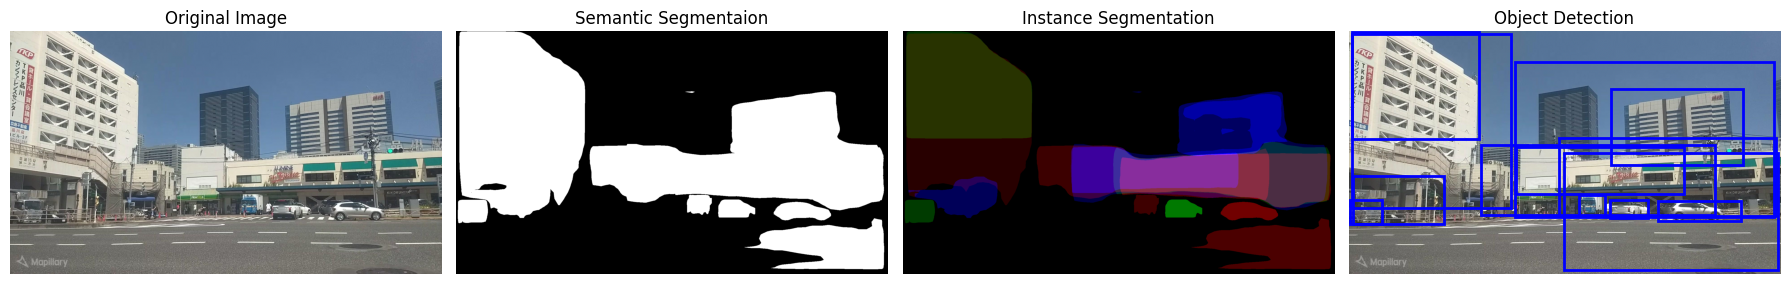

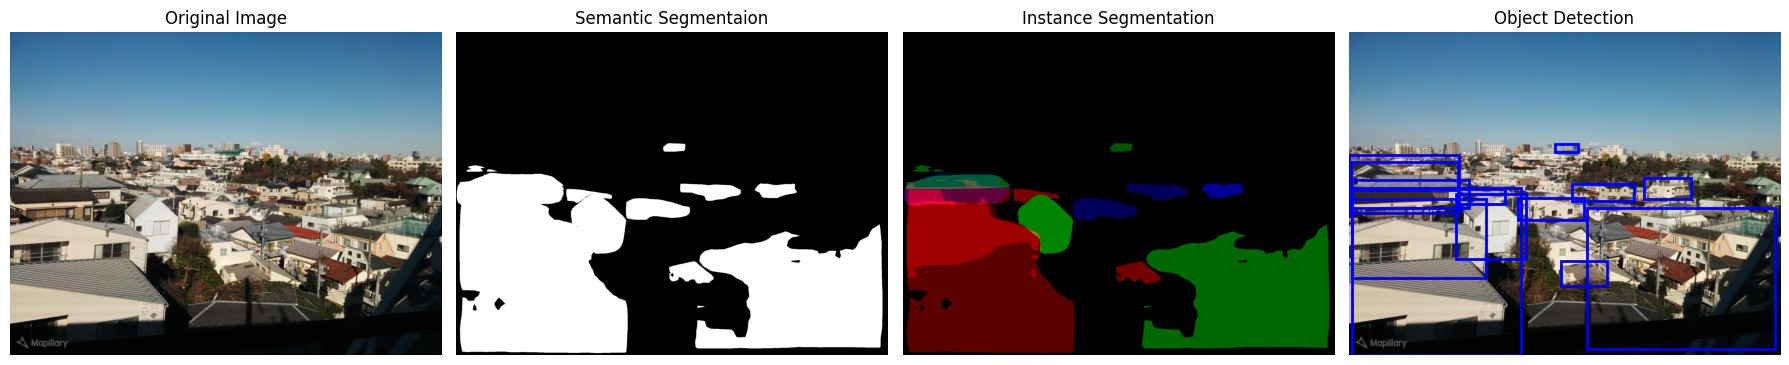

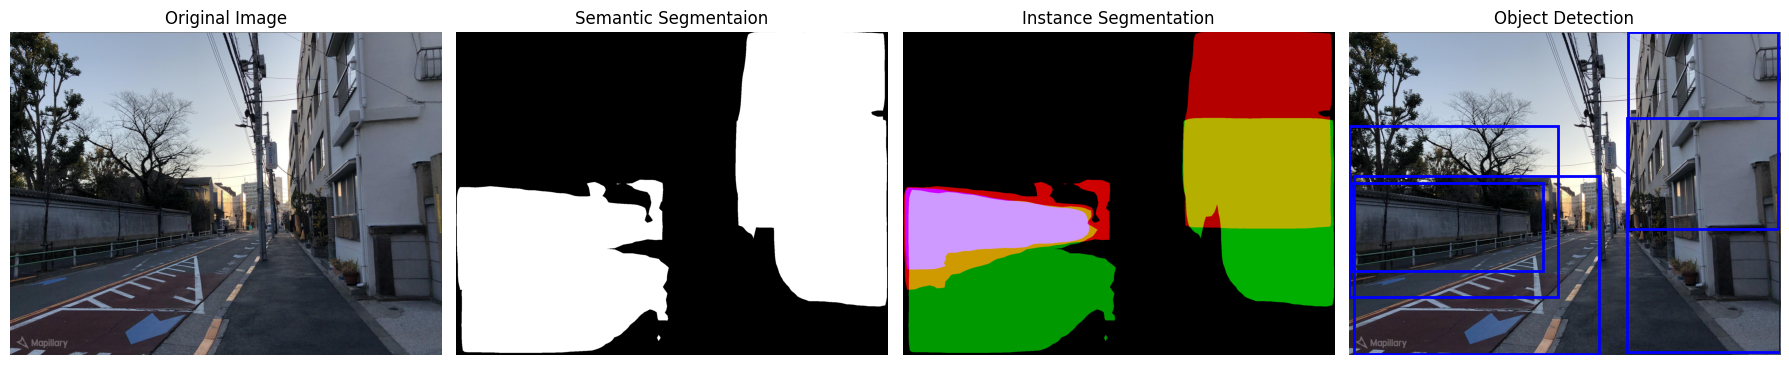

In [ ]:
for im,target in zip(imgs,outs ):
    image = im['image'].data.cpu().numpy().transpose((1,2,0))
    fields = target['instances']._fields
    masks = fields['pred_masks'].detach().data.cpu().numpy().transpose((1,2,0))

    boxes = fields['pred_boxes'].tensor.detach().data.cpu().numpy()

    plot_instant(image, masks, boxes)

Видно, что модель порой ошибается, и восприниает машины за здания

**Упражнение 2**
1. Изучитие следующий код загрузки набора данных [`PennFudanPed`](https://www.cis.upenn.edu/~jshi/ped_html/).
2. Попробуйте обучить одну из моделей `Detectron2` для данного набора данных.

*Примечание* Набор данных  PennFudanPed используется в официальном туториал `PyTorch` по обучению Mask-R-CNN в рамках базового фреймворка [тут](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) и [тут](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb).

## Упражнение 2

Загрузим данные PennFudanPed

In [ ]:
import os
url = "https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip"
root_directory = os.getcwd()
download_and_extract_archive(url, root_directory)

100%|██████████| 53723336/53723336 [00:01<00:00, 29029070.18it/s]


Extracting /kaggle/working/PennFudanPed.zip to /kaggle/working


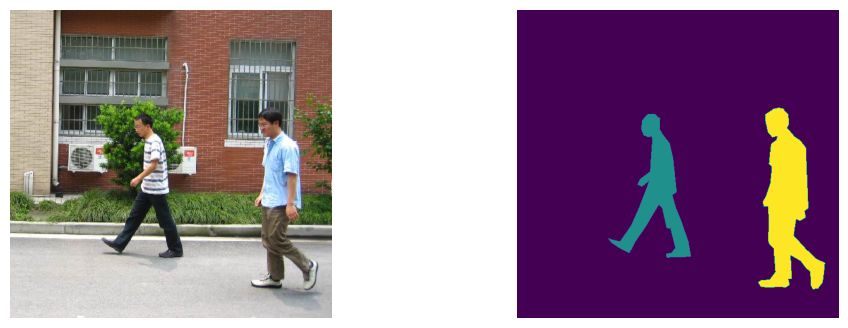

In [ ]:
from PIL import Image
img  = np.asarray(Image.open('PennFudanPed/PNGImages/FudanPed00001.png'))
mask = np.asarray(Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png'))
_,axs = plt.subplots(1,2,figsize=(12,4));
axs[0].imshow(img); axs[0].axis('off');
axs[1].imshow(mask); axs[1].axis('off');plt.show()

Напишем функцию для приведения данных в нужный вид

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from skimage.measure import find_contours

def mask2box(mask):
    pos = np.where(mask)
    xmin, xmax = np.min(pos[1]), np.max(pos[1])
    ymin, ymax = np.min(pos[0]), np.max(pos[0])
    return xmin, ymin,xmax-xmin, ymax-ymin

def pedestrian2COCO(root):

    imgs  = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
    masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
    dataset_dicts = []
    for idx_im,(img_name, mask_name) in enumerate(zip(imgs, masks)):

        record = {}

        img_path  = os.path.join(root, "PNGImages", img_name)
        mask_path = os.path.join(root, "PedMasks",  mask_name)

        img  = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path))
        obj_idxs = np.unique(mask)[1:]
        masks    = mask == obj_idxs[:, None, None]
        num_objs = len(obj_idxs)

        height, width = img.shape[:2]

        record["file_name"] = img_path
        record["image_id"]  = idx_im
        record["height"]    = height
        record["width"]     = width

        objs = []
        for mask in masks:#range(num_objs):
            poly = find_contours(mask.T)[0].reshape(-1,1).squeeze()
            obj = {
                "bbox": [*mask2box(mask)],
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts, masks

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
try:
    DatasetCatalog.pop("data_train")
except:
    pass

try:
    DatasetCatalog.pop("data_val")
except:
    pass

In [ ]:

try:
    dataset_dicts, masks = pedestrian2COCO('./PennFudanPed')
    DatasetCatalog.register("data_train", lambda : dataset_dicts[:-50])
except:
    print('Probably data %s have been already registred')

try:
    dataset_dicts, masks = pedestrian2COCO('./PennFudanPed')
    DatasetCatalog.register("data_val", lambda : dataset_dicts[-50:])
except:
    print('Probably data %s have been already registred')

MetadataCatalog.get("data_train").set(thing_classes=["person"])
MetadataCatalog.get("data_val").set(thing_classes=["person"])

namespace(name='data_val', thing_classes=['person'])

In [ ]:
train_metadata = MetadataCatalog.get("data_train")

In [ ]:
train_metadata.as_dict()

{'name': 'data_train', 'thing_classes': ['person']}

In [ ]:
dataset_dicts, masks = pedestrian2COCO('./PennFudanPed')

In [ ]:
dataset_dicts = dataset_dicts[:-50]

In [ ]:
print('N Train',len(dataset_dicts))
print(dataset_dicts[0].keys())

N Train 120
dict_keys(['file_name', 'image_id', 'height', 'width', 'annotations'])


Посмотрим на данные

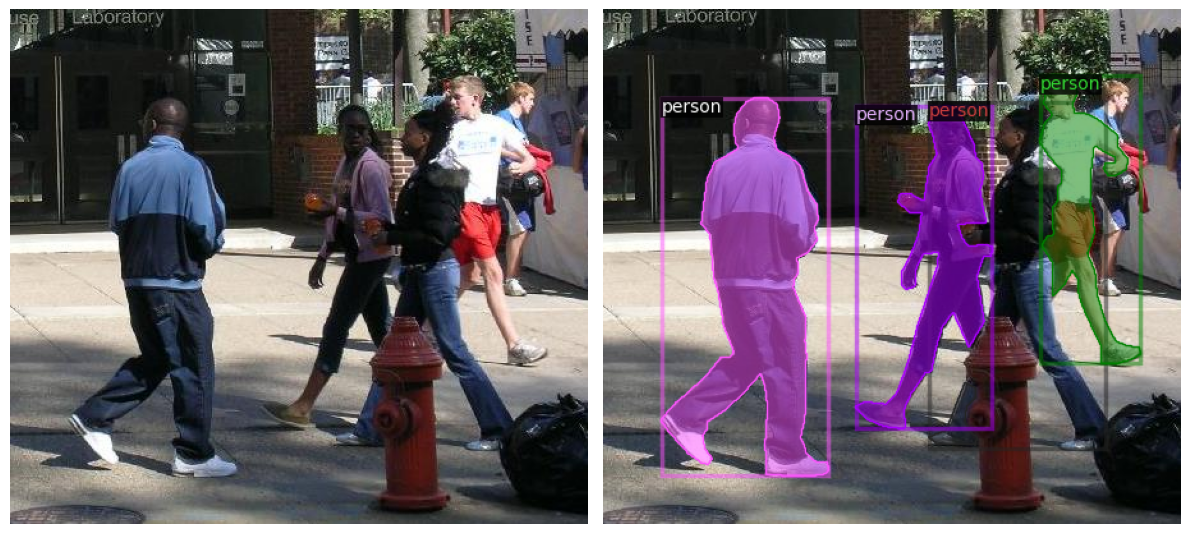

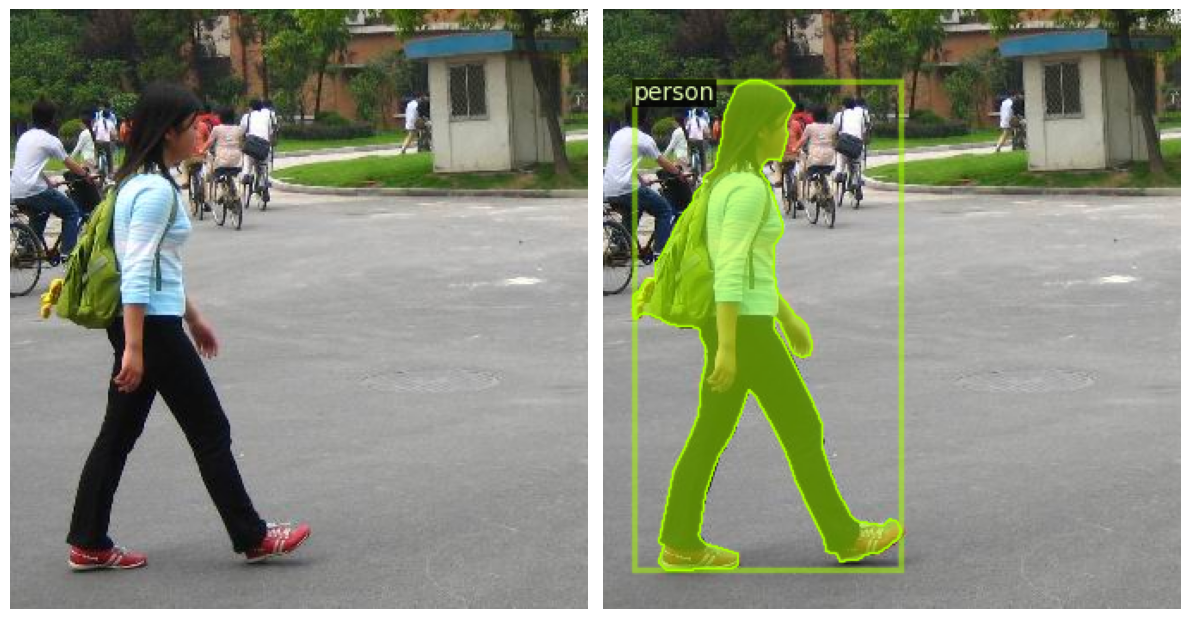

In [ ]:
for d in random.sample(dataset_dicts, 2):
    img   = Image.open(d["file_name"])
    _,axs = plt.subplots(1,2,figsize=(12,8))
    axs[0].imshow(img); axs[0].axis('off')
    visualizer = Visualizer(img, metadata=train_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    axs[1].imshow(out.get_image()); axs[1].axis('off')
    plt.tight_layout();plt.show()

In [ ]:
from detectron2.model_zoo.model_zoo import _ModelZooUrls
mz = _ModelZooUrls()
print("\n".join(list(mz.CONFIG_PATH_TO_URL_SUFFIX.keys())))

COCO-Detection/faster_rcnn_R_50_C4_1x
COCO-Detection/faster_rcnn_R_50_DC5_1x
COCO-Detection/faster_rcnn_R_50_FPN_1x
COCO-Detection/faster_rcnn_R_50_C4_3x
COCO-Detection/faster_rcnn_R_50_DC5_3x
COCO-Detection/faster_rcnn_R_50_FPN_3x
COCO-Detection/faster_rcnn_R_101_C4_3x
COCO-Detection/faster_rcnn_R_101_DC5_3x
COCO-Detection/faster_rcnn_R_101_FPN_3x
COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x
COCO-Detection/retinanet_R_50_FPN_1x
COCO-Detection/retinanet_R_50_FPN_3x
COCO-Detection/retinanet_R_101_FPN_3x
COCO-Detection/rpn_R_50_C4_1x
COCO-Detection/rpn_R_50_FPN_1x
COCO-Detection/fast_rcnn_R_50_FPN_1x
COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x
COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_1x
COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x
COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x
COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x
COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x
COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x
COCO-InstanceSegmentation/mask_rcnn_R_101_DC5_3x
COCO-Insta

Проведем конфигурацию модели object detection

In [ ]:
from detectron2.engine import DefaultTrainer

In [ ]:
from detectron2.data import build_detection_test_loader, build_detection_train_loader

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg)

In [ ]:
BATCH = 2

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("data_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = BATCH
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

Обучим модель

In [ ]:
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True);
trainer = CustomTrainer(cfg)#DefaultTrainer(cfg);

trainer.resume_or_load(resume=False)

model_final_f10217.pkl: 178MB [00:00, 215MB/s]                             


In [ ]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("data_val", )
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [ ]:
dataset_dicts, masks = pedestrian2COCO('./PennFudanPed')

In [ ]:
dataset_dicts = dataset_dicts[-50:]

In [ ]:
print('N Train',len(dataset_dicts))
print(dataset_dicts[0].keys())

N Train 50
dict_keys(['file_name', 'image_id', 'height', 'width', 'annotations'])


In [ ]:
val_metadata = MetadataCatalog.get("data_val")

Посмотрим на результат работы модели на валидационной выборке

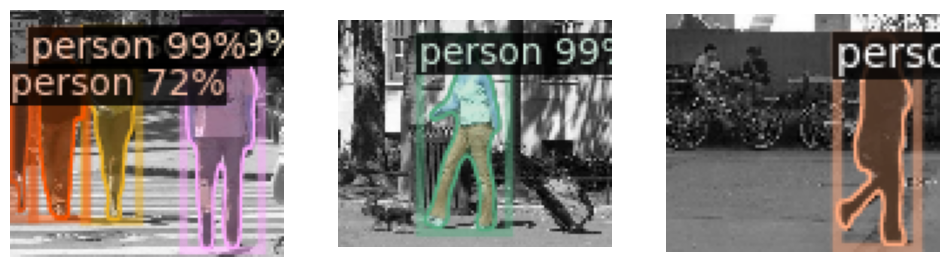

In [ ]:

_, axs = plt.subplots(1,3,figsize=(12,9))

for i,d in enumerate(random.sample(dataset_dicts, 3)):
    im = np.asarray(Image.open(d["file_name"]))
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=train_metadata,
                   scale=0.25,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[i].imshow(out.get_image()); axs[i].axis('off');
plt.show()

Видно, что модель правильно находит людей, однако порой упускает их(как на 3 фото), возможно это связано с тем, что они находятся на заднем плане и модель не может их правильно идентифицировать